In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
import shutil
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.plotting.tools import set_rc_params_article
from numcosmo_py.helper import npa_to_seq
set_rc_params_article(ncol=1,use_tex = bool(shutil.which("latex")))
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
#import GCRCatalogs
#GCRCatalogs.set_root_dir_by_site("nersc")
#from GCR import GCRQuery



#%matplotlib inline

In [2]:
zmin = 0.0
zmax = 1.2
logMmin = 13.0
logMmax = 16.0

#image_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

# Taking some important information about the fiducial cosmological model and survey region
#dc2_cosmology = image_cat.cosmology
#sky_area = image_cat.sky_area

sky_area =  439.790 

dc2_hdul = fits.open("cosmodc2_hmf.fits")
data_dc2 = dc2_hdul[1].data
data_dc2 = Table(data_dc2)
print(data_dc2.columns)


data_dc2 = Table(data_dc2)
#hdu = fits.BinTableHDU(data=data_dc2)
#hdu.writeto('cosmodc2.fits')
print(data_dc2.columns)
data_dc2['halo_mass'] = data_dc2['halo_mass']

print(len(data_dc2))


print("ra interval")
print(data_dc2['ra_true'].min())
print(data_dc2['ra_true'].max())
print('\n')

print("dec interval")
print(data_dc2['dec_true'].min())
print(data_dc2['dec_true'].max())
print('\n')

print("z interval")
print(data_dc2['redshift_true'].min())
print(data_dc2['redshift_true'].max())
print('\n')

print("Mass interval")
print(data_dc2['halo_mass'].min())
print(data_dc2['halo_mass'].max())
print('\n')

print("sky_area = %.3f sqd" % (sky_area))

zmin = data_dc2['redshift_true'].min()
zmax = data_dc2['redshift_true'].max()
lnMmin = data_dc2['halo_mass'].min()
lnMmax = data_dc2['halo_mass'].max()

#lnMmin = 13.0 * np.log(10)
#lnMmax = 13.5 * np.log(10)

<TableColumns names=('halo_id','redshift_true','halo_mass','ra_true','dec_true')>
<TableColumns names=('halo_id','redshift_true','halo_mass','ra_true','dec_true')>
219798
ra interval
47.82629157861663
75.90336852551347


dec interval
-46.56263345432947
-24.641586877718865


z interval
0.01577138900756836
1.0999808311462402


Mass interval
29.933860988335113
35.17898546086178


sky_area = 439.790 sqd


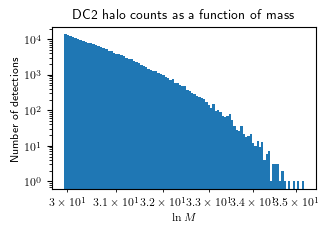

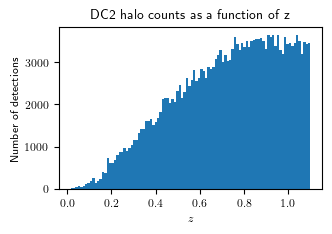

In [3]:
plt.hist(data_dc2['halo_mass'],bins=100)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln M$")
plt.title("DC2 halo counts as a function of mass")
plt.show()

plt.hist(data_dc2['redshift_true'],bins=100)
plt.title("DC2 halo counts as a function of z")
plt.ylabel("Number of detections")
plt.xlabel(r"$z$")
plt.show()

# Cosmological Model

In [4]:
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
#cosmo.omega_x2omega_k()
#cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("Omegax", 0.7352)
cosmo.param_set_by_name("H0",  71  )
cosmo.param_set_by_name("Omegab", 1 - 0.7352 - 0.22)
cosmo.param_set_by_name("Omegac", 0.22)  # 0.2603

cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA =  0.963
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (0.8/ cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(0.8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)



dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)

0.7764593327592988
0.8 0.8 3.059734917887053


# Cluster Mass-Richness and photoz model 

In [5]:
#mass proxy
cluster_m = Nc.ClusterMassNodist(lnM_min=lnMmin, lnM_max=lnMmax)

#photo-z
cluster_z = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)

# Cluster abundance model

## HMF as a function of mass

206163.64336598298


/tmp/ipykernel_330987/2322817226.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  diff = [(abundance[j] - counts_lnM[j])/counts_lnM[j] for j in range(len(lnM)-1)]


204556.476463099
233471.10841407778


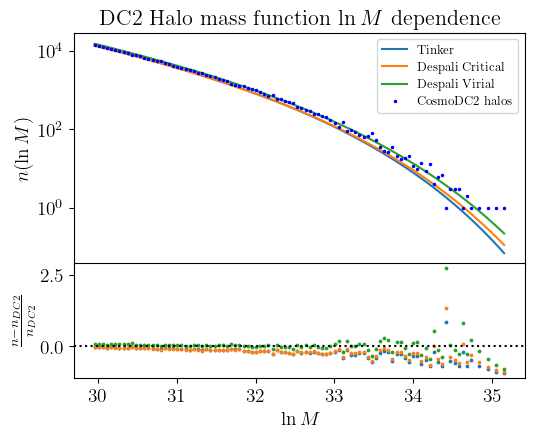

In [6]:
mulfs = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new(), Nc.MultiplicityFuncDespali.new()]
mulf_label = ["Tinker", "Despali Critical" , "Despali Virial"]
nbins=100

lnM = np.linspace(lnMmin, lnMmax , nbins +1)
lnM_bin = [(lnM[j] +lnM[j+1])/2 for j in range(len(lnM)-1)]
counts_lnM, bins = np.histogram(data_dc2['halo_mass'], bins=lnM)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,gridspec_kw={'height_ratios': [2, 1]},figsize=(5,4))
#fig.set_figheight(5)
#fig.set_figwidth(15)
#fig.suptitle("DC2 halos as a function of mass")
for i in range(len(mulfs)):
    diff = []
    mulf = mulfs[i]
    if i == 2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)

    else:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        mulf.set_Delta(200.0)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.prepare(cosmo)
    hmf.set_area(sky_area * (np.pi / 180) ** 2)
    hbias = Nc.HaloBiasTinker.new(hmf)
    cad = Nc.ClusterAbundance.new(hmf, hbias)
    cad.set_area(sky_area * (np.pi / 180) ** 2)
    
    
    cad.prepare(cosmo , cluster_z , cluster_m)
    print(cad.n(cosmo ,cluster_z , cluster_m))
    
    abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM[j]] , [lnM[j+1]], None, [zmin] , [zmax] , None)  for j in range(len(lnM)-1)]
    diff = [(abundance[j] - counts_lnM[j])/counts_lnM[j] for j in range(len(lnM)-1)]

    #PLOT
    
    
    ax1.plot(lnM_bin,abundance,'-', label=mulf_label[i]) #Best fit model
    #plt.axis([lnM_bin[0], lnM_bin[-1], 0.0,counts_lnM.max()])
    
    ax1.set_yscale("log")
    #plt.axis([lnM_bin[0], lnM_bin[-1], counts_lnM.min(),counts_lnM.max()])
    ax2.scatter(lnM_bin,diff,label=mulf_label[i],s=3)


ax1.plot(lnM_bin,counts_lnM,'.b',label='CosmoDC2 halos',ms=3) #Noisy data
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylabel(r"$n(\ln M)$",fontsize=14)
ax1.set_title(r'DC2 Halo mass function $\ln M$ dependence',fontsize=16)
ax1.legend(loc='best',fontsize=9)

ax2.axhline(y=0.0, color='black', linestyle='dotted')
#ax1.grid()
ax2.set_xlabel(r"$\ln M$",fontsize=14)
ax2.set_ylabel(r"$\frac{n - n_{DC2}}{n_{DC2}}$ ",fontsize=14)
#ax2.grid()
#extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('hmfs_cosmodc2_lnM.png', bbox_inches=extent)

extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('residual_lnM.png', bbox_inches=extent)
plt.tight_layout(pad=-0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("residuals_hmf_lnM.jpg",bbox_inches='tight',dpi=300)
plt.show()

## HMF as a function of z

206163.64336598298
204556.476463099
233471.10841407778


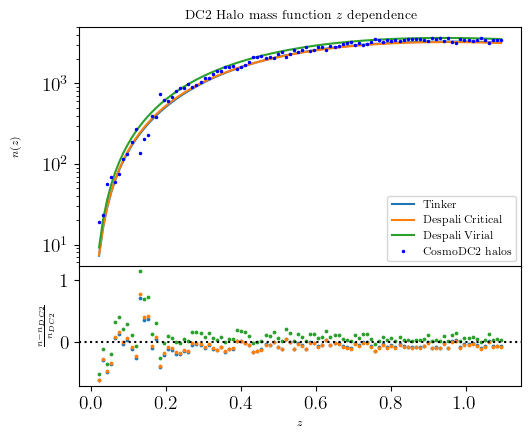

In [7]:
mulfs = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new(), Nc.MultiplicityFuncDespali.new()]
mulf_label = ["Tinker", "Despali Critical" , "Despali Virial"]
nbins=100
z = np.linspace(zmin, zmax , nbins +1)
z_bin = [(z[j] +z[j+1])/2 for j in range(len(z)-1)]
counts_z, bins = np.histogram(data_dc2['redshift_true'], bins=z)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True,gridspec_kw={'height_ratios': [2, 1]},figsize=(5,4))
#fig.suptitle("DC2 halos as a function of z")
for i in range(len(mulfs)):
    diff = []
    mulf = mulfs[i]
    if i == 2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)

    else:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        mulf.set_Delta(200.0)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.prepare(cosmo)
    hmf.set_area(sky_area * (np.pi / 180) ** 2)
    hbias = Nc.HaloBiasDespali.new(hmf)
    cad = Nc.ClusterAbundance.new(hmf, hbias)
    cad.set_area(sky_area * (np.pi / 180) ** 2)
    
    
    cad.prepare(cosmo , cluster_z , cluster_m)
    print(cad.n(cosmo ,cluster_z , cluster_m))
    
    abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnMmin] , [lnMmax], None, [z[j]] , [z[j+1]] , None)  for j in range(len(lnM)-1)]
    diff = [(abundance[j] - counts_z[j])/counts_z[j] for j in range(len(z)-1)]

    #PLOT
    
    
    ax1.plot(z_bin,abundance,'-', label=mulf_label[i]) #Best fit model
    #plt.axis([lnM_bin[0], lnM_bin[-1], 0.0,counts_lnM.max()])
    
    ax1.set_yscale("log")
    #plt.axis([lnM_bin[0], lnM_bin[-1], counts_lnM.min(),counts_lnM.max()])
    ax2.scatter(z_bin,diff, label=mulf_label[i],s=3)


ax1.plot(z_bin,counts_z,'.b',label='CosmoDC2 halos',ms=3) #Noisy data
ax1.set_ylabel(r"$n(z)$",labelpad=16)
ax1.set_title(r'DC2 Halo mass function $z$ dependence')
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.grid()
ax2.axhline(y=0.0, color='black', linestyle='dotted')
ax1.legend(loc='best')
ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$\frac{n - n_{DC2}}{n_{DC2}}$ ")
#ax2.grid()
plt.savefig("residuals_hmf_z.png")

extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('residual_lnM.png', bbox_inches=extent)
plt.tight_layout(pad=-0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("residuals_hmf_z.jpg",bbox_inches='tight',dpi=300)
plt.show()

# Cluster counts binned likelihood

## S matrix 

In [8]:
z_bins_knots = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])
z_bin = [(z_bins_knots[i] +z_bins_knots[i+1])/2 for i in range(len(z_bins_knots)-1)]

lnM_bins_knots = np.array([np.log(1e13), np.log(10**13.5),  np.log(1e14), np.log(10**14.5), np.log(1e15)])
#lnM_bins_knots = np.array([np.log(10**13.0), np.log(10**13.2), np.log(10**13.4), np.log(10**13.5)])
lnM_bins = [(lnM_bins_knots[i] +lnM_bins_knots[i+1])/2 for i in range(len(lnM_bins_knots)-1)]

kernel_z = np.linspace(0.0, 1.9, num=400 + 1)[1:]
kernels_T = np.zeros((len(z_bins_knots)-1, 400))
for i, (zminbin, zmaxbin) in enumerate(zip(z_bins_knots[:-1], z_bins_knots[1:])):
        Dz = zmaxbin - zminbin

        kernel = np.zeros_like(kernel_z)
        kernel[(kernel_z >= zminbin) & (kernel_z <= zmaxbin)] = 1.0
        kernels_T[i] = kernel / Dz
    
S_fullsky_array = PySSC.Sij(kernel_z, kernels_T, cosmo)
S_fullsky = Ncm.Matrix.new_array(S_fullsky_array.flatten(), S_fullsky_array.shape[1])

mean: 2356.0000000000 685.0000000000 139.0000000000 25.0000000000 5874.0000000000 1664.0000000000 388.0000000000 52.0000000000 9988.0000000000 2658.0000000000 591.0000000000 56.0000000000 14038.0000000000 3766.0000000000 696.0000000000 75.0000000000 17722.0000000000 4509.0000000000 735.0000000000 74.0000000000 21200.0000000000 4995.0000000000 798.0000000000 60.0000000000 23909.0000000000 5347.0000000000 758.0000000000 58.0000000000 52223.0000000000 10687.0000000000 1331.0000000000 77.0000000000 26306.0000000000 4900.0000000000 531.0000000000 18.0000000000
[2666.42766806  754.19464131  168.20718687   23.59296114] 

[6395.66218094 1745.14888284  366.26651556   46.23557917] 

[10847.99489875  2843.1320575    557.50910825    62.58584595] 

[15389.34704457  3858.92750557   702.50056116    69.40176648] 

[19541.4553291   4670.49492018   784.56560622    67.53873293] 

[22985.27513442  5216.88684753   803.90353948    59.72793886] 

[25545.90136741  5486.10465593   771.06152796    48.98678201] 

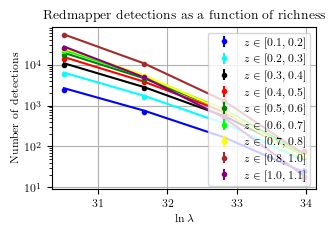

In [9]:
#Mset Preparation
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

bin_counts = []
bin_counts_pure_complete = []
for i in range(len(z_bins_knots)-1):
    bins_coutns_z_i = data_dc2[(data_dc2['redshift_true'] >= z_bins_knots[i]) * (data_dc2['redshift_true'] < z_bins_knots[i+1])]

    for j in range(len(lnM_bins_knots)-1):
        bin_counts.append(len(bins_coutns_z_i[(bins_coutns_z_i['halo_mass'] >= lnM_bins_knots[j]) * (bins_coutns_z_i['halo_mass'] < lnM_bins_knots[j+1]
                                                                                                  )]))

z_bins_vec = Ncm.Vector.new_array(npa_to_seq(z_bins_knots))
lnM_bins_vec = Ncm.Vector.new_array(npa_to_seq(lnM_bins_knots))

nc_data_binned = Nc.DataClusterNCountsGauss.new(cad)
nc_data_binned.set_size((z_bins_vec.len() - 1) * (lnM_bins_vec.len() - 1))
nc_data_binned.set_init(True)
nc_data_binned.use_norma(True)
nc_data_binned.set_z_obs(z_bins_vec)
nc_data_binned.set_lnM_obs(lnM_bins_vec)
nc_data_binned.set_has_ssc(True)
nc_data_binned.set_s_matrix(S_fullsky)
nc_data_binned.set_fix_cov(False)

nc_data_binned.peek_mean().set_array(npa_to_seq(bin_counts))
nc_data_binned.peek_mean().log_vals("mean: " , "%.10f", True)
a, boolen = nc_data_binned.compute_cov(mset)
#a.log_vals("cov" , "%.10f")
#S_fullsky.log_vals("S" , "%.10f")
    
dset.append_data(nc_data_binned)
# Likelihood
lh = Ncm.Likelihood.new(dset)
color_list = ["blue","cyan" , "black", "red" , "green","lime" , "yellow", "brown" , "purple", ]
for i in range(len(z_bins_knots)-1):
    abundance_lnM = np.array  ([cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM_bins_knots[j]] , [lnM_bins_knots[j+1]], None, [z_bins_knots[i]] , [z_bins_knots[i+1]] , None) for j in range(len(lnM_bins_knots)-1)])
    lnR_bins = [(lnM_bins_knots[j] + lnM_bins_knots[j+1])/2 for j in range(len(lnM_bins_knots)-1)]
    bin_counts_z = [bin_counts[ i * (len(lnM_bins_knots)-1) + j] for j in range(len(lnM_bins_knots)-1)]
    err_bin_counts_z = [np.sqrt(bin_counts[ i * (len(lnM_bins_knots)-1) + j]) for j in range(len(lnM_bins_knots)-1)]
    plt.errorbar(lnM_bins, bin_counts_z, yerr=err_bin_counts_z,label=r"$z \in [%.1f,%.1f]$" % (z_bins_knots[i] , z_bins_knots[i+1]),fmt='.',color=color_list[i])
    plt.plot(lnM_bins,abundance_lnM,color=color_list[i])

    print(abundance_lnM, "\n")

ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
experiment = Ncm.ObjDictStr()
experiment.set("likelihood", lh)
experiment.set("model-set", mset)
ser.to_binfile(dset, "cosmodc2.dataset.gvar")
ser.dict_str_to_yaml_file(experiment, "cosmodc2.yaml")
ser.array_to_yaml_file(mfunc_oa,"cosmodc2.functions.yaml")

  
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.grid()
plt.legend(loc='best')
plt.savefig("hmf_binned.pdf")
plt.show()

# Fit

In [10]:
#Mset Preparation
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)

mset.prepare_fparam_map()
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
#fit.run(Ncm.FitRunMsgs.SIMPLE)
#fit.log_info()
#fit.obs_fisher()
#fit.log_covar()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterNCountsGauss
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22                [FREE]
#   -     Omegax[02]:  0.7352              [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -          w[07]: -1                   [FREE]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#-------------------------------------------------------------------

In [11]:
prim.props.ln10e10ASA = 3.147  
print(cosmo.sigma8(psf))

prim.props.ln10e10ASA =  3.147   - 1*0.07011 
print(cosmo.sigma8(psf))

prim.props.ln10e10ASA =  3.147    + 1*0.07011 
print(cosmo.sigma8(psf))

0.8356787498540841
0.8068915468549327
0.8654929843790263


# MCMC

In [ ]:
nwalkers = 200

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(0.1)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL,mfunc_oa)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_cosmodc2.fits")

esmcmc.start_run()
esmcmc.run(500)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0200.
#   Number of threads: 0002.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterNCountsGauss
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Model set:
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22       

Removed no burn in


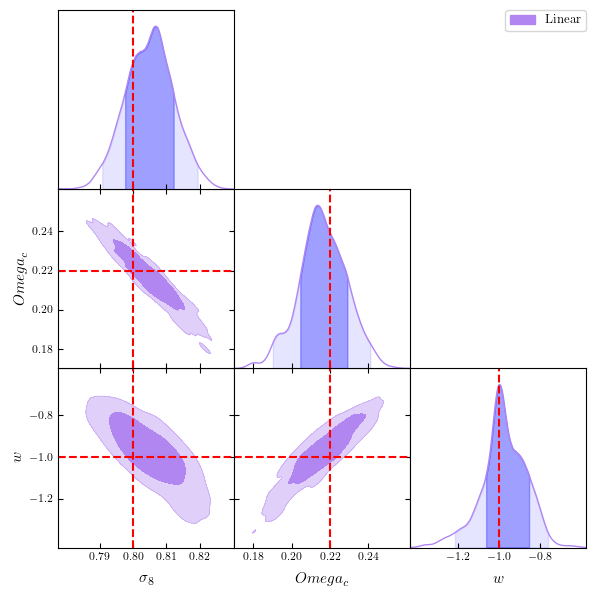

In [11]:
data_fit_full = (
    pd.DataFrame(fits.open("mcmc_cosmodc2.fits")[1].data).iloc[:, 1:4].T
)

data_fit_void = np.array(data_fit_full)
data_fit = []
for item in data_fit_void:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

names = [
    "1",
    "2",
    "4"
]
labels = [
    r"\sigma_8",
    r"Omega_c",
    r"w",
]
settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples3 = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)

bf = [0.8, 0.22, -1.0]


samples3.removeBurn(0.5)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples3],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        "Linear",
    ],
)

for i, param in enumerate(names):
    density = samples3.get1DDensity(param)
    x = density.x
    y = density.P
    lower1sigma = density.getLimits(0.68)[0]
    upper1sigma = density.getLimits(0.68)[1]
    lower2sigma = density.getLimits(0.95)[0]
    upper2sigma = density.getLimits(0.95)[1]
    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower1sigma) & (x <= upper1sigma)),
        color="blue",
        alpha=0.3,
        label="1σ" if i == 0 else "",
    )

    g2.subplots[i, i].fill_between(
        x,
        y,
        where=((x >= lower2sigma) & (x <= upper2sigma)),
        color="blue",
        alpha=0.1,
        label="2σ" if i == 0 else "",
    )


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="red", linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="red", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="red", linestyle="--")


plt.show()

